## **Libraries**

In [1]:
### Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re
import math
import csv
import pickle
import random
import statistics as stats
from time import perf_counter

### Our Modules
from src.sentiment_scorer import HashSetSentimentScorer, TrieSentimentScorer, tokenize
from src.utils import measure_time, measure_memory

print("Imports successful")

Imports successful


## **Importing Kaggle Dataset**

In [2]:
## Load Dataset
print("Current working dir:", os.getcwd())
DATASET_PATH = Path("data/airline.csv")

if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

print("Dataset located at:", DATASET_PATH)

Current working dir: C:\Users\marcl\DSA Assignment - Sentiment Analysis
Dataset located at: data\airline.csv


In [3]:
## Initialize Dataset as pandas dataframe
df = pd.read_csv(DATASET_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(3)

Rows: 41396
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating', 'recommended']


,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,NaN,NaN,Economy,NaN,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1


In [4]:
reviews = df.iloc[:, 6].fillna("").astype(str).tolist()
print(f"Loaded {len(reviews):,} reviews from column '{df.columns[6]}'")
print()
print("Example review:\n", reviews[0][:300])

Loaded 41,396 reviews from column 'content'

Example review:
 Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were served complimentary. Inbound flights SKP/LJU/FRA CRJ900. each 1 hour 30 min flight. Skyshop menu was in a seat pocket and drinks/snacks were for sale. All flight crews were friendly. 


##  **Importing Lexicon Dataset**

In [5]:
POS_PATH = Path("data/positive-words.txt")
NEG_PATH = Path("data/negative-words.txt")

LEX_TOKEN = re.compile(r"[a-z][a-z'\-\+]*$")

def load_lexicon(path: Path):
    words = []
    for line in path.read_text(encoding="latin-1").splitlines():
        s = line.strip().lower()
        if not s or s.startswith(";"):
            continue
        if LEX_TOKEN.fullmatch(s):
            words.append(s)
    return sorted(set(words))
    
pos_words = load_lexicon(POS_PATH)
neg_words = load_lexicon(NEG_PATH)

print(f"Loaded {len(pos_words):,} positive and {len(neg_words):,} negative words")
print("Examples (pos):", pos_words[:10])
print("Examples (neg):", neg_words[:10])

Loaded 2,006 positive and 4,776 negative words
Examples (pos): ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples (neg): ['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']


## **Sanity/Proof-of-Concept: Review Scoring**

In [6]:
# --- Step 1: Score all reviews using both data structures ---
hs = HashSetSentimentScorer(pos_words, neg_words)
tr = TrieSentimentScorer(pos_words, neg_words)

hs_scores = [hs.score_review(r) for r in reviews]
tr_scores = [tr.score_review(r) for r in reviews]

# --- Step 2: Compute summary statistics ---
total = len(reviews)
agree = np.sum(np.array(hs_scores) == np.array(tr_scores))
mismatch = total - agree

print("Scoring completed successfully.")
print(f"Total reviews scored: {total:,}")
print(f"Matching scores (HashSet vs Trie): {agree:,}")
print(f"Mismatches: {mismatch:,}")

# sentiment distribution
pos_count = np.sum(np.array(hs_scores) > 0)
neu_count = np.sum(np.array(hs_scores) == 0)
neg_count = np.sum(np.array(hs_scores) < 0)

print("\nHashSet Sentiment Distribution:")
print(f"  Positive: {pos_count:,} ({pos_count/total*100:.2f}%)")
print(f"  Neutral:  {neu_count:,} ({neu_count/total*100:.2f}%)")
print(f"  Negative: {neg_count:,} ({neg_count/total*100:.2f}%)")



Scoring completed successfully.
Total reviews scored: 41,396
Matching scores (HashSet vs Trie): 41,396
Mismatches: 0

HashSet Sentiment Distribution:
  Positive: 24,646 (59.54%)
  Neutral:  3,534 (8.54%)
  Negative: 13,216 (31.93%)


In [7]:
# --- Step 1: Randomly sample a few full reviews ---
random.seed(201)
sample_size = 10
idxs = random.sample(range(len(reviews)), sample_size)

# --- Step 2: Prepare comparison table with full review text ---
rows = []
for i in idxs:
    r = str(reviews[i]).replace("\n", " ").strip()
    hs_score = hs_scores[i]
    tr_score = tr_scores[i]
    rows.append({
        "Row #": i,
        "Full Review Text": r,
        "HashSet Score": hs_score,
        "Trie Score": tr_score,
        "Match": "Match" if hs_score == tr_score else "Mismatch"
    })

demo = pd.DataFrame(rows, columns=["Row #", "Full Review Text", "HashSet Score", "Trie Score", "Match"])

# --- Step 3: Highlight mismatches for visibility ---
def highlight_mismatch(row):
    color = "background-color: #ffeaea" if row["Match"] == "Mismatch" else ""
    return [color] * len(row)

demo.style.apply(highlight_mismatch, axis=1).format({
    "HashSet Score": "{:+d}",
    "Trie Score": "{:+d}"
})


,Row #,Full Review Text,HashSet Score,Trie Score,Match
0,4397,VIE to KIV. The experience was quite odd like going back into the Soviet days as they were using a Yak-40 on the flight. Staff friendly and relatively professional although it felt almost like a charter flight. The meal was quite good and flight was on time. The cabin layout was really bizarre with something looking like a couch near the front of the plane and little leg room in my seat. The fact that they didn't de-ice the plane (it was snowing hard at takeoff) freaked me out a bit too. Not sure if they're still using the Yak-40 but if you happen to get on this one it's certainly a unique experience if you're up for it.,+2,+2,Match
1,21338,"I've been flying back and forth with JetBlue for the past 6 years. I fly once every other month. At first I was so satisfied with the service that I have never flown with any other airline. But lately the past year especially the service has gone downhill. The staff used to be so friendly and always smiling. My last Flight was in December my TV was not working when I informed the flight attendant I got nothing but attitude and her answer was ""I don't know what to tell you."" After six years of using them that was my last and final time.",+2,+2,Match
2,27547,"BNE to Singapore. Checking in using machines just about everyone needed assistance. The seat allocation for my husband and I were many rows apart. Everyone ended up at the bag drop where this problem was sorted. A330 Airbus was cramped tired ditto the crew. Food less than ordinary no tray but just main meal container (one was cracked) plus roll and envelope with cutlery etc. Overheard passenger asking cabin crew member to recommend which of the meal choices - the reply was ""Madam I would recommend eating before you board the plane""! The pre- landing snack was a sort of pizza contained in a thick cardboard box - made in England. Entertainment programme was minimal. Return flight fortunately on a rather more modern plane better range of entertainment but the crew were brusque uncaring and disorganised - would not feel confident about them in a crisis. Never again on Qantas.",-1,-1,Match
3,240,Flew LHR to SVO 27/3/15 returned 4/4/15. Outbound A321 return A330-300. Both trips were comfortable with cabin crew all very helpful and pleasant to a non Russian Speaker. We were in economy both ways. The plane was clean the toilets were fine and the food and drinks provided were good for airline food in our family experience. Overall a very pleasant experience No IFE on way out as small plane but lots on way back choice was good.,+8,+8,Match
4,18533,CGK to PLY pleased with the service. Without delays and had good take-offs and landing. Inflight entertainment was good but could be better. Comfortable seat if compared to other airlines economy class. Price could be cheaper but not too expensive for service like that. The food was delicious for plane food.,+6,+6,Match
5,21376,Heathrow to Delhi. Very easy check-in at Heathrow using terminal 4 is great because it's a small terminal so queues are far shorter for check-in and security than in other terminals. My flight was delayed an hour. Had good inflight service and the food and entertainment was adequate. My main problem with this airline compared to using other airlines is the fellow passengers. Be prepared to put up with people pushing their way forward at the boarding gate and for a relatively noisy flight. So although the airline is fine if you can get an equivalent flight on this route I'd take it.,+2,+2,Match
6,30793,KCH-SIN A short and pleasant flight. Despite the crowded plane the cabin crew is still warm and friendly. SilkAir has finally launched new menus which makes frequent traveler more appertising. The ground staff is friendly and extends warm welcome to everyone. Also SilkAir has also introduced the new autumn theme seating. Simple soothing yet truly makes passengers feel exclusive. SilkAir also departs and arrives on tim

##  **Experiment 1 - Lookup Runtime vs Number of Reviews (N)**

**Objective**
- This experiment compares the runtime performance of HashSet and Trie when used to check if words in a review appear in a sentiment lexicon (positive or negative word list).
- We want to see how their theoretical time complexities play out when processing thousands of reviews.


**Algorithmic/Theory Context**
1. HashSet: Hash-Table-Based Constant-Time Lookup
- A HashSet stores elements in an underlying hash table
- Each word is passed through a hash function, which converts a string into an integer hash value.
- This hash is then modded by the table size to compute an index, effectively pointing to a “bucket” in memory.
- Because this process avoids traversing structures element-by-element, the expected lookup cost is constant time O(1), assuming a good hash function and even distribution of entries

2. Trie: Tree-Based Prefix Search Structure
- A Trie (prefix tree) organizes words as paths of characters
- Each node represents a single character, and edges represent transitions between successive letters. For instance, inserting “good” creates a path: root → g → o → o → d.
- This traversal requires visiting m nodes (where m = length of the word), giving a lookup complexity of O(m).
- Unlike a hash table, a Trie’s structure depends on the characters of the word rather than its hash value.

**Hypothesis**
With this theory in mind, it seems clear that Trie should be slower than HashSet by an extreme margin because O(m) is theoretically much worse than O(1)

**Experiment 1 Design**
- To test this hypothesis, we will measure how long both data structures (HashSet and Trie) take to process different amounts of reviews
- Each review is made up of many words, and for every word, the program checks whether it exists in the positive or negative lexicon
- Then it will make a judgement (positive or negative) on the review based on counts of positive or negative words

Independent Variable: The number of reviews (N) processed

Controlled Variables:
1. Same positive and negative word lists (lexicons)
2. Same review dataset, in the same order
3. Same scoring logic (each word checked once per review)
4. Fixed random seed (201, the course code) to make sampling consistent

Measured Metrics:
1. Total Runtime (s) – total time taken for each data structure to process all reviews
2. Average Time per Review (ms) – how much time each review takes on average
3. Relative Runtime (Trie ÷ HashSet) – to see how many times slower the Trie is compared to the HashSet

### **1.1 Testing Metrics Results**

In [8]:
def time_scorer(scorer, texts):
    """Return how many seconds it takes for scorer to process all given reviews."""
    start_time = perf_counter()
    for review in texts:
        scorer.score_review(review)   # run the scoring
    end_time = perf_counter()
    elapsed = end_time - start_time
    return elapsed

different_Ns   = [500, 1000, 2000, 5000, 10000, 20000, 30000, 40000]
repetitions = 3 # multiple runs for a stable/average median

results = []
prev_N = None
prev_hs_time = None
prev_tr_time = None

for N in different_Ns:
    subset = reviews[:N]
    hs = HashSetSentimentScorer(pos_words, neg_words)
    tr = TrieSentimentScorer(pos_words, neg_words)

    hs_times = [time_scorer(hs, subset) for i in range(repetitions)]
    tr_times = [time_scorer(tr, subset) for i in range(repetitions)]

    hs_med = stats.median(hs_times)
    tr_med = stats.median(tr_times)

    if prev_N is None:
        n_growth = None
        hs_growth = None
        tr_growth = None
    else:
        n_growth = N / prev_N
        hs_growth = hs_med / prev_hs_time
        tr_growth = tr_med / prev_tr_time

    results.append({
        "Reviews Processed": N,
        "HashSet Runtime (s)": hs_med,
        "Trie Runtime (s)": tr_med,
        "Relative Runtime (Trie ÷ HashSet)": tr_med / hs_med,
        "Avg Time/Review – HashSet (ms)": (hs_med / N) * 1000,
        "Avg Time/Review – Trie (ms)": (tr_med / N) * 1000,
        "N Growth (×)": n_growth,
        "Runtime Growth (×) — HashSet": hs_growth,
        "Runtime Growth (×) — Trie": tr_growth,
    })

    # update previous
    prev_N = N
    prev_hs_time = hs_med
    prev_tr_time = tr_med


### **1.1.1 Experiment 1 Results (Table)**

In [9]:
dfN = pd.DataFrame(results)

dfN_style = dfN.style.format({
    "HashSet Runtime (s)": "{:.4f}",
    "Trie Runtime (s)": "{:.4f}",
    "Relative Runtime (Trie ÷ HashSet)": "{:.2f}×",
    "N Growth (×)": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — HashSet": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — Trie": lambda v: "" if pd.isna(v) else f"{v:.2f}",
})
dfN_style


,Reviews Processed,HashSet Runtime (s),Trie Runtime (s),Relative Runtime (Trie ÷ HashSet),Avg Time/Review – HashSet (ms),Avg Time/Review – Trie (ms),N Growth (×),Runtime Growth (×) — HashSet,Runtime Growth (×) — Trie
0,500,0.0185,0.0392,2.12×,0.037066,0.078451,,,
1,1000,0.0350,0.0767,2.19×,0.034968,0.076718,2.00,1.89,1.96
2,2000,0.0732,0.1571,2.15×,0.036577,0.078539,2.00,2.09,2.05
3,5000,0.1966,0.4474,2.28×,0.039328,0.089482,2.50,2.69,2.85
4,10000,0.3973,0.8816,2.22×,0.039732,0.088162,2.00,2.02,1.97
5,20000,0.8038,1.8172,2.26×,0.040189,0.090860,2.00,2.02,2.06
6,30000,1.1554,2.5537,2.21×,0.038513,0.085122,1.50,1.44,1.41
7,40000,1.5879,3.4669,2.18×,0.039697,0.086672,1.33,1.37,1.36


#### **Conclusion**
- The table shows that runtime for both HashSet and Trie imeplementations increases roughly proportionally with number of reviews (N), this confirms O(N) time complexity for both data structures

- "Avg Time per Review" remains nearly constant across all dataset sizes, this means that each additional review adds a fixed processing cost (≈ 0.04 ms for HashSet, ≈ 0.09 ms for Trie)

- The “Runtime Growth (×)” columns indicate near-linear growth (≈ 2× when N doubles), which is also reflected visually in Graph 1 (Total Runtime Scaling with Dataset Size) and Graph 4 (Runtime Growth Factor vs Dataset Growth Factor).

- The Relative Runtime (Trie ÷ HashSet) ratio stabilizes around 2.2×, indicating a consistent constant-factor slowdown

- These quantitative results are visually corroborated by Graph 1 (Log–Log Scaling), Graph 2 (Average Processing Time), and Graph 3 (Relative Runtime).

### **1.1.2 Experiment 1 Results (Graphs)**

#### **Graph 1 - Total Runtime Scaling with Dataset Size (Log–Log Plot)**

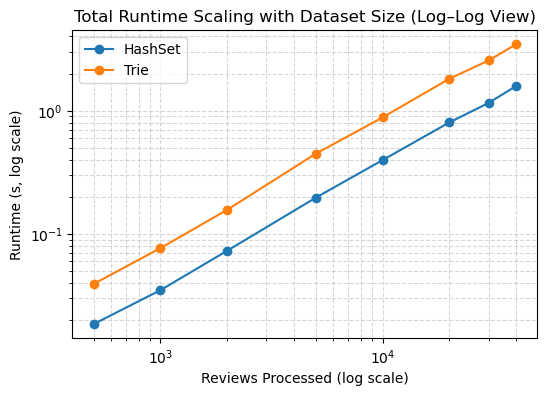

In [10]:
plt.figure(figsize=(6,4))
plt.loglog(dfN["Reviews Processed"], dfN["HashSet Runtime (s)"], marker="o", label="HashSet")
plt.loglog(dfN["Reviews Processed"], dfN["Trie Runtime (s)"], marker="o", label="Trie")
plt.xlabel("Reviews Processed (log scale)")
plt.ylabel("Runtime (s, log scale)")
plt.title("Total Runtime Scaling with Dataset Size (Log–Log View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- Both lines are nearly straight and parallel on a log–log plot, meaning total runtime grows linearly proportionate to input size which indicates O(N) time complexity
- The constant vertical gap between the two lines (roughly 2.2× apart) visually represents the Relative Runtime ratio from the table. 
- This confirms that the Trie’s runtime is consistently about double that of HashSet, while maintaining identical time complexity, O(N).

#### **Graph 2 - Average Processing Time per Review**

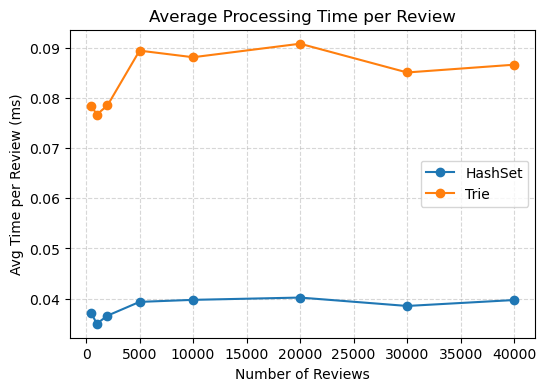

In [11]:
dfN["Avg Time per Review – HashSet (ms)"] = (dfN["HashSet Runtime (s)"] / dfN["Reviews Processed"])*1000
dfN["Avg Time per Review – Trie (ms)"]    = (dfN["Trie Runtime (s)"] / dfN["Reviews Processed"])*1000
plt.figure(figsize=(6,4))
plt.plot(dfN["Reviews Processed"], dfN["Avg Time per Review – HashSet (ms)"], marker="o", label="HashSet")
plt.plot(dfN["Reviews Processed"], dfN["Avg Time per Review – Trie (ms)"], marker="o", label="Trie")
plt.xlabel("Number of Reviews")
plt.ylabel("Avg Time per Review (ms)")
plt.title("Average Processing Time per Review")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- Both HashSet and Trie exhibit flat per-review runtime costs, reinforcing the idea that processing time per review is independent of dataset size.

- The HashSet averages ≈ 0.04 ms/review, while the Trie averages ≈ 0.085 ms/review, a constant factor of ≈ 2.2×, This aligns perfectly with the Relative Runtime ratio in both the table and Graph 3 (Relative Runtime (Trie ÷ HashSet)).

- This constant per review runtime cost confirms that the observed total runtime scaling in graph 1 (Total Runtime Scaling with Dataset Size (Log–Log View)) is from increasing number of processed reviews (N) rather than increasing per review runtime costs.

#### **Graph 3 - Relative Slowdown of Trie vs HashSet**

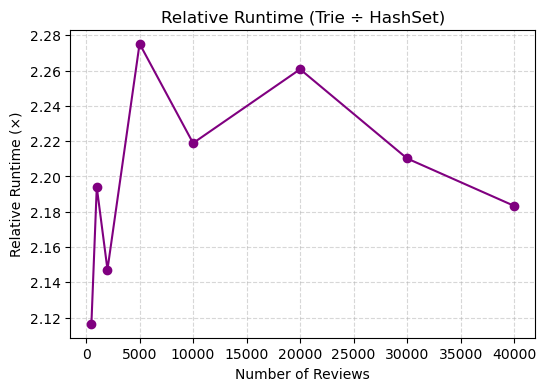

In [12]:
plt.figure(figsize=(6,4))
plt.plot(dfN["Reviews Processed"], dfN["Relative Runtime (Trie ÷ HashSet)"], marker="o", color="purple")
plt.xlabel("Number of Reviews")
plt.ylabel("Relative Runtime (×)")
plt.title("Relative Runtime (Trie ÷ HashSet)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- The runtime ratio (Trie ÷ HashSet) stabalizes between 2.1x - 2.3x across all dataset sizes, this shows that the performance difference between Trie and HashSet is consistent and independent of dataset size

- The trend matches the constant vertical offset seen in Graph 1 (Total Runtime Scaling with Dataset Size (Log–Log View)) and also the runtime ratio in the table.

- These findings imply that the Trie implementation's extra cost arises purely from constant-factor overheads (per-character traversal, pointer navigation), not from higher time complexity

#### **Graph 4 - Runtime Growth Factor vs Dataset Growth Factor**

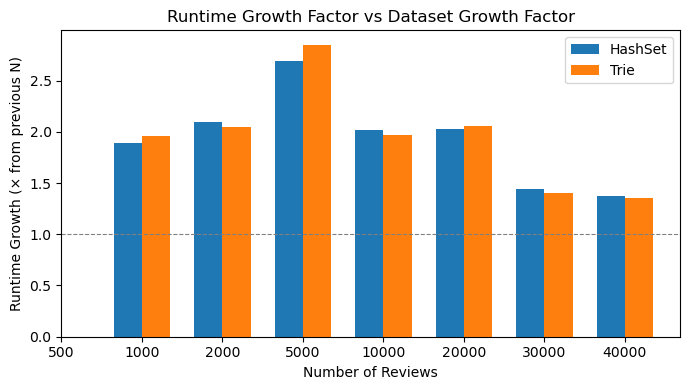

In [13]:
plt.figure(figsize=(7,4))
width = 0.35
plt.bar(dfN.index - width/2, dfN["Runtime Growth (×) — HashSet"], width=width, label="HashSet")
plt.bar(dfN.index + width/2, dfN["Runtime Growth (×) — Trie"], width=width, label="Trie")
plt.xticks(dfN.index, dfN["Reviews Processed"])
plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel("Runtime Growth (× from previous N)")
plt.xlabel("Number of Reviews")
plt.title("Runtime Growth Factor vs Dataset Growth Factor")
plt.legend(); plt.tight_layout(); plt.show()

#### **Findings/Conclusions**
- When dataset size roughly doubles (N Growth ≈ 2×), both HashSet and Trie show a comparable Runtime Growth ≈ 2×, confirming linear scaling.

- We believe the fluctuation/anomaly around N = 5000 is from cache effects or variance rather than algorithmic causes

- These bar heights align closely with the “Runtime Growth” column in the table, further supporting O(N) complexity for both structures.


### **1.2 Experiment 1 Overall Conclusion & Learning Points**

**1. Theoretical vs Real Life Application**
- In theory, HashSet lookups run in O(1) average time, while Trie lookups take O(m) time, where m is the length of the word.

- However, in practice these assumptions break down:
    1. Real text data (like english reviews) contain words that are typically only 5-8 characters long, and this length doesn't increase with dataset size (N). This means that m behaves like a small fixed constant so Trie's O(m) effectively behaves closer to O(1) in real world workloads

    2. Even though Hashset lookup is theoretically O(1), it must still compute the hash of every word which requires scanning through each of the word's m characters once. This means that there is a hidden cost of O(m) inside the hash computational step with the difference being that its performed using a highly optimized C function (Python set is implemented in C) rather than through pointer traversal

- As a result, both structures end up performing roughly the same amount of per-word work in practice, touching each character once, and their total runtime scales linearly with the number of reviews processed (O(N)). The only difference comes from constant factors such as memory access patterns and implementation overhead, not from asymptotic behavior.

- Thus this experiment shows an important reality of DSA; Big-O notation describes growth trends, not actual real world speed. What seems like a massive gap in theory (O(1) vs O(m)) can collapse to a small constant difference in real code as real data has bounded input sizes and real machines have constant-factor costs that matter.


**2. Constant Factor Costs Still matter**
- In class, we often focus on asymptotic growth, so it can feel like constant-time work is unimportant. For example, when analysing a recursive algorithm we often ignore non-recursive work if they are O(1)
  
- However, even though both structures have the same overall time complexity O(N), the Trie implementation was consistently about 2.2× slower than the HashSet

- This is due to constant-factor costs such as per-character traversal, Python object overheard, and meomory-access inefficiencies (e.g., scattered node pointers causing cache misses).

- These finding highlights that Big-O explains growth trends, but real-world performance depends heavily on these constants
   
**3. Context and Problem May Matter More Than Algorithmic Efficiency**
- It’s easy to assume that “faster = better" in theory but in practice there is no single silver-bullet algorithm or data structure that outperforms others in all situations, The most efficient choice always depends on the problem’s context and what operations are most common
  
- In our sentiment analysis task, we only needed exact word lookups, so the HashSet was clearly better: simple, predictable, and faster

- However, in applications involving prefix searches, autocomplete systems, or hierarchical word dictionaries, the Trie data structure may be the smarter option even if it seems slower by raw lookup time as its structure supports those operations more naturally

- This brings to light an important lesson. Focusing on algorithmic efficiency, while certainly better than relying on improved hardware (as shown in the course slides), is still only part of "better". Real-world performance also depends on how well a data structure fits the task, the programming language environment, and the actual data being processed


##  **Experiment 2 - Lookup Runtime vs Lexicon Size (K)**

### **2.1 Testing Metrics Results**

In [14]:
# Same time_scorer used in experiment 1
def time_scorer(scorer, texts):
    start = perf_counter()
    for review in texts:
        scorer.score_review(review)
    return perf_counter() - start

# Fixed review subset size for a fair comparison across K
N_subset = min(30_000, len(reviews))  
subset = reviews[:N_subset]

# Sensible K values based on available words
total_pos = len(pos_words)
total_neg = len(neg_words)
TOTAL_AVAILABLE = total_pos + total_neg

candidate_K = [500, 1000, 2000, 4000, 6000, 8000]
Kvals = [k for k in candidate_K if k <= TOTAL_AVAILABLE]
if len(Kvals) == 0:  # fallback if lists are tiny
    Kvals = [min(500, TOTAL_AVAILABLE)]

random.seed(201)

def subsample_words(words, k):
    words = list(words)
    if k >= len(words):
        return words[:]  # take all
    return random.sample(words, k)

repetitions = 3  # multiple runs for a stable/average median

results = []
for K in Kvals:
    # Balance pos/neg roughly 50/50 (clip to available)
    k_pos = min(K // 2, total_pos)
    k_neg = min(K - k_pos, total_neg)

    pos_k = subsample_words(pos_words, k_pos)
    neg_k = subsample_words(neg_words, k_neg)

    # Build scorers
    hsK = HashSetSentimentScorer(pos_k, neg_k)
    trK = TrieSentimentScorer(pos_k, neg_k)

    # Timing (median of reps)
    hs_times = [time_scorer(hsK, subset) for i in range(repetitions)]
    tr_times = [time_scorer(trK, subset) for i in range(repetitions)]
    hs_med = stats.median(hs_times)
    tr_med = stats.median(tr_times)

    results.append({
        "Lexicon Size (K)": K,
        "HashSet Time (s)": hs_med,
        "Trie Time (s)": tr_med,
        "Relative Slowdown (Trie ÷ HashSet)": tr_med / hs_med,
        "Avg Time/Review – HashSet (ms)": (hs_med / N_subset) * 1000,
        "Avg Time/Review – Trie (ms)":    (tr_med / N_subset) * 1000,
    })

In [15]:
dfK = pd.DataFrame(results)

# Nicely formatted view
dfK_style = dfK.style.format({
    "HashSet Time (s)": "{:.4f}",
    "Trie Time (s)": "{:.4f}",
    "Relative Slowdown (Trie ÷ HashSet)": "{:.2f}×",
    "Avg Time/Review – HashSet (ms)": "{:.3f}",
    "Avg Time/Review – Trie (ms)": "{:.3f}",
})
dfK_style

,Lexicon Size (K),HashSet Time (s),Trie Time (s),Relative Slowdown (Trie ÷ HashSet),Avg Time/Review – HashSet (ms),Avg Time/Review – Trie (ms)
0,500,1.2098,2.3884,1.97×,0.040,0.080
1,1000,1.1446,2.4846,2.17×,0.038,0.083
2,2000,1.1608,2.4370,2.10×,0.039,0.081
3,4000,1.1620,2.5623,2.21×,0.039,0.085
4,6000,1.1611,2.6119,2.25×,0.039,0.087
